In [1]:
import math
import numpy as np
import numpy.random as npr  
from pylab import plt, mpl
import pandas as pd
from scipy.stats import norm

$$dS_t = rS_tdt+\sqrt{v_t}S_tdW_{1, t}$$
$$dv_t = \kappa(\theta - v_t)dt + \sigma \sqrt{v_t} dW_{2, t}$$
$$dW_{1, t}dW_{2,t} = \rho dt$$

In [2]:
import scipy.stats as scs    # function to output some statistics numbers
def print_statistics(a1, a2):
    ''' Prints selected statistics.
    
    Parameters
    ==========
    a1, a2: ndarray objects
        results objects from simulation
    '''
    sta1 = scs.describe(a1)  
    sta2 = scs.describe(a2)  
    print('%14s %14s %14s' % 
        ('statistic', 'data set 1', 'data set 2'))
    print(45 * "-")
    print('%14s %14.3f %14.3f' % ('size', sta1[0], sta2[0]))
    print('%14s %14.3f %14.3f' % ('min', sta1[1][0], sta2[1][0]))
    print('%14s %14.3f %14.3f' % ('max', sta1[1][1], sta2[1][1]))
    print('%14s %14.3f %14.3f' % ('mean', sta1[2], sta2[2]))
    print('%14s %14.3f %14.3f' % ('std', np.sqrt(sta1[3]), np.sqrt(sta2[3])))
    print('%14s %14.3f %14.3f' % ('skew', sta1[4], sta2[4]))
    print('%14s %14.3f %14.3f' % ('kurtosis', sta1[5], sta2[5]))

In [3]:
S0 = 4500.    # ETH price in late Nov
r = 1    # risk free rate, in order to simulate the bear market, set it as -0.7 (expected 70% down for ETH for a whole year)
v0 = 0.5    # implied variance in the beginning
kappa = 3    # mean-reversion rate
theta = 1    # long-term average variance 120%
sigma = 0.3    # vol of vol
rho = -0.2    # correlation between price and vol, set to negative
T = 0.5    # 9 months, 9/12

In [4]:
corr_mat = np.zeros((2, 2))
corr_mat[0, :] = [1.0, rho]
corr_mat[1, :] = [rho, 1.0]
cho_mat = np.linalg.cholesky(corr_mat) 
# cho_mat 

In [5]:
M = 270 * 24    # hourly simulation, 9 months divided by 270*24 means hour
I = 10000    # number of paths: 10k
dt = T / M

In [6]:
ran_num = npr.standard_normal((2, M + 1, I))  
v = np.zeros_like(ran_num[0])
vh = np.zeros_like(v)
v[0] = v0
vh[0] = v0

In [7]:
# simulate variance
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])  
    vh[t] = (vh[t - 1] +
             kappa * (theta - np.maximum(vh[t - 1], 0)) * dt +
             sigma * np.sqrt(np.maximum(vh[t - 1], 0)) * 
             math.sqrt(dt) * ran[1])  
v = np.maximum(vh, 0)

In [8]:
# simulate underlying price
S = np.zeros_like(ran_num[0])
S[0] = S0
for t in range(1, M + 1):
    ran = np.dot(cho_mat, ran_num[:, t, :])
    S[t] = S[t - 1] * np.exp((r - 0.5 * v[t]) * dt +
                    np.sqrt(v[t]) * ran[0] * np.sqrt(dt))

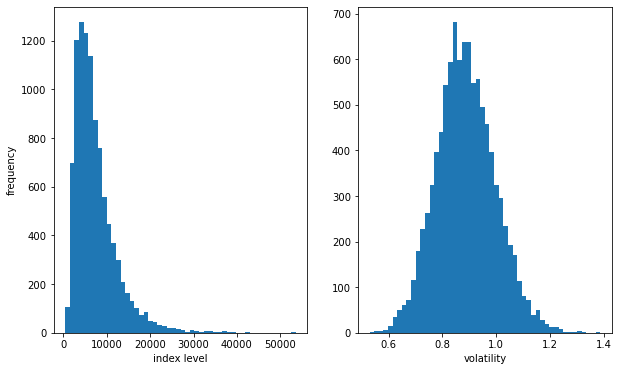

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1.hist(S[-1], bins=50)
ax1.set_xlabel('index level')
ax1.set_ylabel('frequency')
ax2.hist(v[-1], bins=50)
ax2.set_xlabel('volatility');
# plt.savefig('../.../distribution.png');

     statistic     data set 1     data set 2
---------------------------------------------
          size      10000.000      10000.000
           min        412.266          0.530
           max      53561.595          1.386
          mean       7392.008          0.887
           std       4990.695          0.109
          skew          2.186          0.221
      kurtosis          8.449          0.125


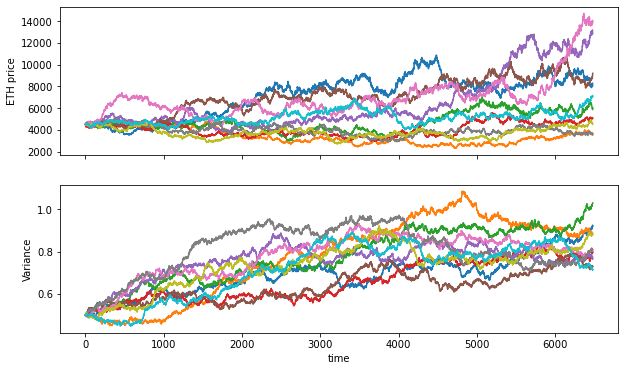

In [10]:
print_statistics(S[-1], v[-1])
     
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                               figsize=(10, 6))
ax1.plot(S[:, :10], lw=1.5)
ax1.set_ylabel('ETH price')
ax2.plot(v[:, :10], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('Variance');
# plt.savefig('../../10paths_sample.png');

The most bearish price in the end:  412.2655062728065
The path index which has most bearish price in the end:  5762


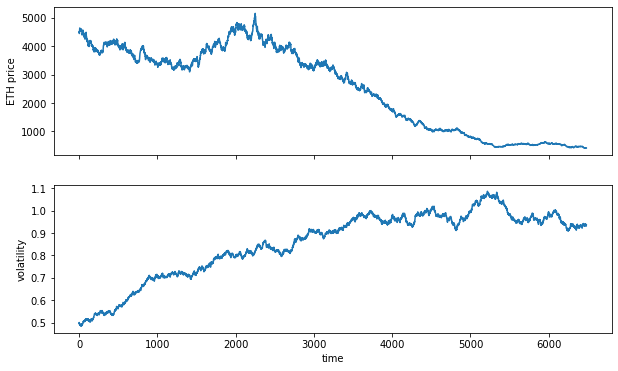

In [11]:
most_drawdown_price = min(S[-1,:])
print('The most bearish price in the end: ', most_drawdown_price)
path_index_lowest_price = int(np.where(S[-1,:] == most_drawdown_price)[0])
print('The path index which has most bearish price in the end: ', path_index_lowest_price)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                               figsize=(10, 6))
ax1.plot(S[:, [path_index_lowest_price]], lw=1.5)
ax1.set_ylabel('ETH price')
ax2.plot(v[:, [path_index_lowest_price]], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('volatility');

In [12]:
stdDev = np.std(S[:,:], axis=0)
min_stdDev = min(np.std(S[:,:], axis=0))    
max_stdDev = max(np.std(S[:,:], axis=0))   

In [13]:
min_index = int(np.where(stdDev == min_stdDev)[0])
max_index = int(np.where(stdDev == max_stdDev)[0])

print("the path # that has the min realized vol:", min_index)
print("the path # that has the min realized vol:", max_index)

the path # that has the min realized vol: 5487
the path # that has the min realized vol: 7292


Blue: path with min realized 
  Yellow: path with max realized vol


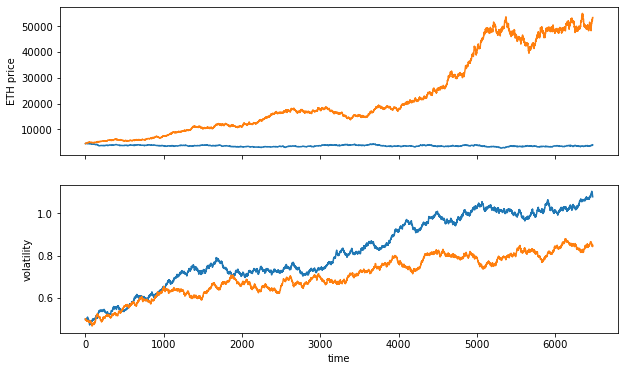

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True,
                               figsize=(10, 6))
ax1.plot(S[:, [min_index,max_index]], lw=1.5)
ax1.set_ylabel('ETH price')
ax2.plot(v[:, [min_index, max_index]], lw=1.5)
ax2.set_xlabel('time')
ax2.set_ylabel('volatility');
print("Blue: path with min realized \n  Yellow: path with max realized vol")

In [15]:
df = pd.DataFrame(S[:, [min_index,max_index]], columns = ['price with min realizedVol','price with max realizedVol'])

In [16]:
df

,price with min realizedVol,price with max realizedVol
0,4500.000000,4500.000000
1,4532.885024,4476.835350
2,4553.513622,4472.690085
3,4562.783300,4529.577622
4,4580.005491,4566.287525
...,...,...
6476,3915.921837,52490.394411
6477,3933.306618,53000.814896
6478,3963.362523,53270.235228
6479,3972.656128,53270.427601


In [17]:
df[['impVol with min realizedVol','impVol with max realizedVol']] = v[:, [min_index,max_index]].tolist()

In [18]:
df[['maxDrawDownPrice']] = S[:,[path_index_lowest_price]].tolist()
df[['maxDDImpVol']] = v[:,[path_index_lowest_price]].tolist()

In [19]:
df

,price with min realizedVol,price with max realizedVol,impVol with min realizedVol,impVol with max realizedVol,maxDrawDownPrice,maxDDImpVol
0,4500.000000,4500.000000,0.500000,0.500000,4500.000000,0.500000
1,4532.885024,4476.835350,0.494502,0.496412,4514.077293,0.498048
2,4553.513622,4472.690085,0.497525,0.496471,4504.774411,0.497470
3,4562.783300,4529.577622,0.498560,0.494103,4463.539969,0.495596
4,4580.005491,4566.287525,0.497588,0.495697,4446.762832,0.498027
...,...,...,...,...,...,...
6476,3915.921837,52490.394411,1.088150,0.846812,419.623273,0.938031
6477,3933.306618,53000.814896,1.084122,0.843686,411.233669,0.935214
6478,3963.362523,53270.235228,1.082193,0.842241,412.102230,0.934484
6479,3972.656128,53270.427601,1.079644,0.845886,412.644541,0.931234


In [20]:
# df.to_csv('path_price and imp vol.csv')

In [21]:
# S[i][j] means the the underlying value in ith time steps and jth path

In [22]:
S[:, 0]

array([4500.        , 4507.22982468, 4564.32148624, ..., 8251.85584915,
       8160.52984123, 8061.55245891])

In [23]:
v[:,0]

array([0.5       , 0.50134732, 0.500402  , ..., 0.92529513, 0.92004522,
       0.91878059])

In [24]:
np.sqrt(v[:,0])

array([0.70710678, 0.70805884, 0.70739098, ..., 0.96192262, 0.95918988,
       0.95853043])

In [25]:
df_test = pd.DataFrame()
df_test['UnderlyingPrice']=S[:, 10]
df_test['HourlyReturn']=df_test['UnderlyingPrice'].pct_change()
df_test['impVol'] = np.sqrt(v[:, 10]).tolist()    # array v is the implied variance not volatility, need to sqrt

In [26]:
df_test

,UnderlyingPrice,HourlyReturn,impVol
0,4500.000000,NaN,0.707107
1,4466.330236,-0.007482,0.709055
2,4457.398184,-0.002000,0.710871
3,4463.527768,0.001375,0.711548
4,4472.798912,0.002077,0.714702
...,...,...,...
6476,2387.079993,-0.021205,1.022084
6477,2391.974275,0.002050,1.022833
6478,2413.474315,0.008988,1.021683
6479,2382.462981,-0.012849,1.020265


In [27]:
length_1m = 30*24
length_3m = 30*3*24
scaling_factor_HrtoYr= np.sqrt(365*24) 
df_test['1MrealizedVol'] = df_test['HourlyReturn'].rolling(length_1m).std()
df_test['1MrealizedVol'] = df_test['1MrealizedVol']*scaling_factor_HrtoYr
df_test['3MrealizedVol'] = df_test['HourlyReturn'].rolling(length_3m).std()
df_test['3MrealizedVol'] = df_test['3MrealizedVol']*scaling_factor_HrtoYr
df_test

,UnderlyingPrice,HourlyReturn,impVol,1MrealizedVol,3MrealizedVol
0,4500.000000,NaN,0.707107,NaN,NaN
1,4466.330236,-0.007482,0.709055,NaN,NaN
2,4457.398184,-0.002000,0.710871,NaN,NaN
3,4463.527768,0.001375,0.711548,NaN,NaN
4,4472.798912,0.002077,0.714702,NaN,NaN
...,...,...,...,...,...
6476,2387.079993,-0.021205,1.022084,0.897566,0.835873
6477,2391.974275,0.002050,1.022833,0.897600,0.835873
6478,2413.474315,0.008988,1.021683,0.898014,0.836048
6479,2382.462981,-0.012849,1.020265,0.897209,0.836433


In [28]:
hour = np.arange(S[:,10].shape[0])
df_test['tau'] = hour[::-1].tolist()
df_test['tau'] = df_test['tau']/(365*24)
df_test

,UnderlyingPrice,HourlyReturn,impVol,1MrealizedVol,3MrealizedVol,tau
0,4500.000000,NaN,0.707107,NaN,NaN,0.739726
1,4466.330236,-0.007482,0.709055,NaN,NaN,0.739612
2,4457.398184,-0.002000,0.710871,NaN,NaN,0.739498
3,4463.527768,0.001375,0.711548,NaN,NaN,0.739384
4,4472.798912,0.002077,0.714702,NaN,NaN,0.739269
...,...,...,...,...,...,...
6476,2387.079993,-0.021205,1.022084,0.897566,0.835873,0.000457
6477,2391.974275,0.002050,1.022833,0.897600,0.835873,0.000342
6478,2413.474315,0.008988,1.021683,0.898014,0.836048,0.000228
6479,2382.462981,-0.012849,1.020265,0.897209,0.836433,0.000114


## European Call Theta and Gamma: 
$$Theta: \Theta = \frac{S_0N(d_1)\sigma}{2\sqrt{\tau}}-rKe^{-r\tau}N(d_2)$$
$$Gamma: \Gamma = \frac{N(d_1)}{S\sigma\sqrt{\tau}}$$
    
NOTE that when underlying price goes deep in the money ($S$ much larger than $K$, $S>>K$, DITM):    
    
    
$$\lim_{\frac{S_0}{K}\to+\infty}d_1 =\lim_{\frac{S_0}{K}\to+\infty} \frac{ln(S_0/K) + (r+\frac{1}{2}\sigma^2)\tau}{\sigma \sqrt{\tau}} = +\infty$$
    
$$d_2 = d_1 - \sigma \sqrt{\tau} \to +\infty$$

$$N(d_1)\to 1, N(d_2) \to 1$$
    
$$Theta: \Theta = \frac{S_0N(d_1)\sigma}{2\sqrt{\tau}}-rKe^{-r\tau}N(d_2) \to \frac{S_0\sigma}{2\sqrt{\tau}}-rKe^{-r\tau}$$
$$Gamma: \Gamma = \frac{N(d_1)}{S\sigma\sqrt{\tau}} \to \frac{1}{S\sigma\sqrt{\tau}}$$


In [29]:
def BS(S, K, tau, r, sigma, **kwargs):
    d1_numerator = np.log(S/K)+ (r+0.5*(sigma**2))*tau
    d1_denominator = sigma * np.sqrt(tau)
    d1 = d1_numerator/d1_denominator
    d2 = d1-sigma*np.sqrt(tau)
    call_value = S*norm.cdf(d1)-K*np.exp(-r*tau)*norm.cdf(d2)
    return call_value
def delta(S, K, tau, r, sigma, **kwargs):
    d1_numerator = np.log(S/K)+ (r+0.5*(sigma**2))*tau
    d1_denominator = sigma * np.sqrt(tau)
    d1 = d1_numerator/d1_denominator
    delta = norm.cdf(d1)
    return delta

In [30]:
# BS function Unit Test/Validation
print(BS(100, 100, 0.25, 0, 0.2))    # suppose to be around 0.4 * S * sigma * sqrt(tau) = 0.4*100*0.2*0.5 = 4
print(BS(4500, 4500*1.2, 0.739726, 0.1, 1))    # suppose to be 1337
print(delta(100, 100, 0.25, 0, 0.2))
print(delta(0.1, 100, 0.739726, 0.1, 1))  # suppose to close to 0
print(BS(45000, 4500, 0.0, 0.1, 1))    # suppose to be 1337


3.987761167674492
1337.7343404616506
0.5199388058383725
2.833705679488596e-14
40500.0


/var/folders/k_/swxk2_jn1dl6w_dbw9rz3x200000gp/T/ipykernel_15605/3770077869.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = d1_numerator/d1_denominator


In [31]:
df_test['callValue'] = df_test.apply(lambda x: BS(x['UnderlyingPrice'], df_test['UnderlyingPrice'][0]*1.2, x['tau'], 0.1, x['impVol']), axis=1)
df_test['Delta'] = df_test.apply(lambda x: delta(x['UnderlyingPrice'], df_test['UnderlyingPrice'][0]*1.2, x['tau'], 0.1, x['impVol']), axis=1)
# df_test['DeltaUSDValue'] = df_test['Delta']*df_test['UnderlyingPrice']
df_test

/var/folders/k_/swxk2_jn1dl6w_dbw9rz3x200000gp/T/ipykernel_15605/3770077869.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = d1_numerator/d1_denominator
/var/folders/k_/swxk2_jn1dl6w_dbw9rz3x200000gp/T/ipykernel_15605/3770077869.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = d1_numerator/d1_denominator


,UnderlyingPrice,HourlyReturn,impVol,1MrealizedVol,3MrealizedVol,tau,callValue,Delta
0,4500.000000,NaN,0.707107,NaN,NaN,0.739726,8.966674e+02,5.501041e-01
1,4466.330236,-0.007482,0.709055,NaN,NaN,0.739612,8.810925e+02,5.457296e-01
2,4457.398184,-0.002000,0.710871,NaN,NaN,0.739498,8.788835e+02,5.449111e-01
3,4463.527768,0.001375,0.711548,NaN,NaN,0.739384,8.831537e+02,5.459666e-01
4,4472.798912,0.002077,0.714702,NaN,NaN,0.739269,8.929248e+02,5.481519e-01
...,...,...,...,...,...,...,...,...
6476,2387.079993,-0.021205,1.022084,0.897566,0.835873,0.000457,1.060646e-305,7.616613e-306
6477,2391.974275,0.002050,1.022833,0.897600,0.835873,0.000342,0.000000e+00,0.000000e+00
6478,2413.474315,0.008988,1.021683,0.898014,0.836048,0.000228,0.000000e+00,0.000000e+00
6479,2382.462981,-0.012849,1.020265,0.897209,0.836433,0.000114,0.000000e+00,0.000000e+00


In [32]:
# compute daily returns using pandas pct_change()
df_test['optionPnL'] = df_test['callValue'].diff()
# df_test['optionPnl']
# df_test['optionPnl'] = df_test['optionPnl'][1:]    # skip first row with NA 
df_test['cumulativeOptionPnL'] = df_test['optionPnL'].cumsum()
# df_test = df_test.drop(['cumulativePnl'], axis=1)
# df_test['cumulativePnL'] = df_test['cumulativePnL'].reset_index()
# df_test['cumulativeOptionPnL'] = df_test['cumulativeOptionPnL']+ df_test['callValue'][0] 
# df_test['deltaPositionPnL'] = -1*df_test['DeltaUSDValue'].diff()
# df_test['deltaCumPnL'] = df_test['deltaPositionPnL'].cumsum()
# df_test['portfolioCumPnL'] = df_test['deltaCumPnL'] + df_test['cumulativeOptionPnL']
df_test['deltaPositionPnL_new'] = -df_test['UnderlyingPrice'].diff() * df_test['Delta'].shift()
df_test['deltaCumPnL_new'] = df_test['deltaPositionPnL_new'].cumsum()
df_test['portfolioPnL'] = df_test['optionPnL']+df_test['deltaPositionPnL_new']
df_test['portfolioCumPnL_new'] = df_test['deltaCumPnL_new'] + df_test['callValue']
df_test['1MRealizedVol-impVol'] = df_test['1MrealizedVol'] - df_test['impVol']
df_test['3MRealizedVol-impVol'] = df_test['3MrealizedVol'] - df_test['impVol']

df_test

,UnderlyingPrice,HourlyReturn,impVol,1MrealizedVol,3MrealizedVol,tau,callValue,Delta,optionPnL,cumulativeOptionPnL,deltaPositionPnL_new,deltaCumPnL_new,portfolioPnL,portfolioCumPnL_new,1MRealizedVol-impVol,3MRealizedVol-impVol
0,4500.000000,NaN,0.707107,NaN,NaN,0.739726,8.966674e+02,5.501041e-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4466.330236,-0.007482,0.709055,NaN,NaN,0.739612,8.810925e+02,5.457296e-01,-1.557492e+01,-15.574925,1.852187e+01,18.521874,2.946949e+00,899.614354,NaN,NaN
2,4457.398184,-0.002000,0.710871,NaN,NaN,0.739498,8.788835e+02,5.449111e-01,-2.209028e+00,-17.783952,4.874485e+00,23.396359,2.665458e+00,902.279812,NaN,NaN
3,4463.527768,0.001375,0.711548,NaN,NaN,0.739384,8.831537e+02,5.459666e-01,4.270253e+00,-13.513699,-3.340079e+00,20.056280,9.301745e-01,903.209986,NaN,NaN
4,4472.798912,0.002077,0.714702,NaN,NaN,0.739269,8.929248e+02,5.481519e-01,9.771046e+00,-3.742653,-5.061735e+00,14.994545,4.709311e+00,907.919297,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6476,2387.079993,-0.021205,1.022084,0.897566,0.835873,0.000457,1.060646e-305,7.616613e-306,-5.674043e-233,-896.667405,1.612316e-231,892.816509,1.555576e-231,892.816509,-0.124518,-0.186211
6477,2391.974275,0.002050,1.022833,0.897600,0.835873,0.000342,0.000000e+00,0.000000e+00,-1.060646e-305,-896.667405,-3.727786e-305,892.816509,-4.788432e-305,892.816509,-0.125232,-0.186959
6478,2413.474315,0.008988,1.021683,0.898014,0.836048,0.000228,0.000000e+00,0.000000e+00,0.000000e+00,-896.667405,-0.000000e+00,892.816509,0.000000e+00,892.816509,-0.123669,-0.185635
6479,2382.462981,-0.012849,1.020265,0.897209,0.836433,0.000114,0.000000e+00,0.000000e+00,0.000000e+00,-896.667405,0.000000e+00,892.816509,0.000000e+00,892.816509,-0.123056,-0.183832


In [33]:
1099.579517 - 1093.832678

5.746838999999909

In [34]:
# df_test.to_csv('test_OnePath_idx10.csv')

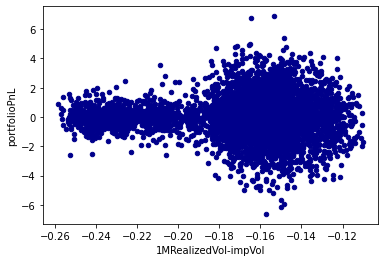

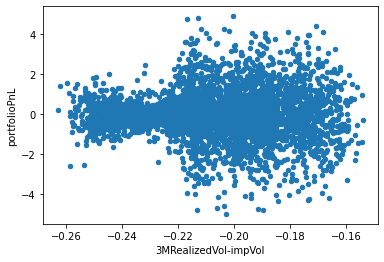

In [35]:
ax1 = df_test.plot.scatter(x='1MRealizedVol-impVol', y='portfolioPnL', c='DarkBlue')
ax2 = df_test.plot.scatter(x='3MRealizedVol-impVol', y='portfolioPnL')

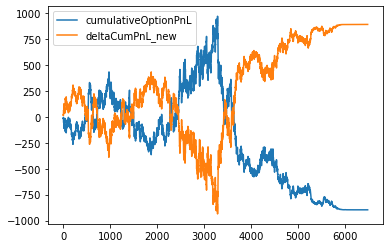

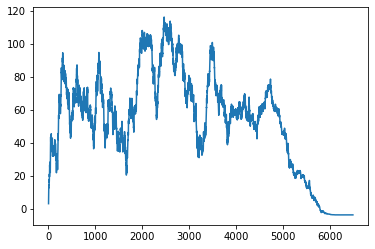

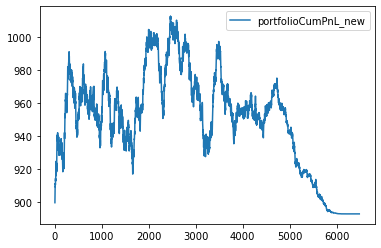

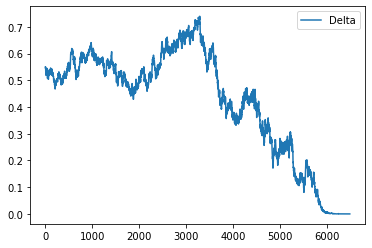

In [36]:
df_test['cumulativeOptionPnL'].plot(legend="OptionCumPnL")
# df_test['UnderlyingPrice'].plot(legend='ETH_price')
df_test['deltaCumPnL_new'].plot(legend="DeltaCumPnL")
plt.show()
plt.plot(df_test['cumulativeOptionPnL']+df_test['deltaCumPnL_new'])
plt.show()
# df_test['portfolioCumPnL'].plot(legend='PnL')
df_test['portfolioCumPnL_new'].plot(legend='PnL_new')
plt.show()
# df_test['portfolioCumPnL'].plot(legend='PnL')
# plt.show()
df_test['Delta'].plot(legend = "Delta")
plt.show()

In [37]:
# s1 = pd.Series(['a', 'b'])
# s2 = pd.Series(['c', 'd'])
# df_test2 = pd.concat([s1, s2], axis=1)
# s3 = pd.Series(['e', 'f'])
# s4 = pd.Series(['g', 'h'])
# df_test2 = pd.concat([df_test2, s3], axis=1)
# df_test2 = pd.concat([df_test2, s4], axis=1)
# df_test2

In [38]:
# for loop to generate all paths
df_pathwisePortPnL = pd.DataFrame()    # pathwise portoflio cumulative PnL holder
df_calloption = pd.DataFrame()    # call option value holder
df_callDelta = pd.DataFrame()    # call delta value holder
# num_paths = S.shape[1]/100    # 100 paths make the machine not to die
num_paths = 500    # 500 paths
for i in range(num_paths):    # calc portfolio PnL for each path
    df_temp = pd.DataFrame(S[:, i], columns = ['UnderlyingPrice'])
    df_temp['impVol'] = np.sqrt(v[:, i]).tolist()    # array v is the implied variance not volatility, need to sqrt
    hour = np.arange(S[:,i].shape[0])
    df_temp['tau'] = hour[::-1].tolist()
    df_temp['tau'] = df_temp['tau']/(365*24)
    df_temp['callValue'] = df_temp.apply(lambda x: BS(x['UnderlyingPrice'], df_test['UnderlyingPrice'][0]*1.2, x['tau'], 0.1, x['impVol']), axis=1)
    df_temp['Delta'] = df_temp.apply(lambda x: delta(x['UnderlyingPrice'], df_test['UnderlyingPrice'][0]*1.2, x['tau'], 0.1, x['impVol']), axis=1)
    # df_test['DeltaUSDValue'] = df_test['Delta']*df_test['UnderlyingPrice']
    df_temp['optionPnL'] = df_temp['callValue'].diff()
    # df_test['cumulativeOptionPnL'] = df_test['optionPnL'].cumsum()
    # df_test['cumulativeOptionPnL'] = df_test['cumulativeOptionPnL']+ df_test['callValue'][0]    # add call initial value as it is free to get
    # df_test['deltaPositionPnL'] = -1*df_test['DeltaUSDValue'].diff()    # previous wrong calc
    df_temp['deltaPositionPnL'] = -df_temp['UnderlyingPrice'].diff() * df_temp['Delta'].shift()
    df_temp['deltaCumPnL'] = df_temp['deltaPositionPnL'].cumsum()
    df_temp['portfolioCumPnL'] = df_temp['deltaCumPnL'] + df_temp['callValue']
    path_index = str(i)
    df_pathwisePortPnL = pd.concat([df_pathwisePortPnL,df_temp['portfolioCumPnL']], axis=1)
    df_calloption = pd.concat([df_calloption,df_temp['callValue']], axis=1)    
    df_callDelta = pd.concat([df_callDelta, df_temp['Delta']], axis=1)

/var/folders/k_/swxk2_jn1dl6w_dbw9rz3x200000gp/T/ipykernel_15605/3770077869.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = d1_numerator/d1_denominator
/var/folders/k_/swxk2_jn1dl6w_dbw9rz3x200000gp/T/ipykernel_15605/3770077869.py:11: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = d1_numerator/d1_denominator


In [39]:
column_names = [str(a) for a in range(int(num_paths))]
df_pathwisePortPnL.columns = column_names
df_calloption.columns = column_names

# df_pathwisePortPnL.tail()
df_calloption.tail()

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
6476,2901.093960,2.685183e-84,592.923418,3.182965e-02,7781.730912,3389.842922,8407.233788,2.761321e-101,5.085357e-14,1670.758387,...,1.382291e-96,2108.449769,25892.872037,221.192160,1.641433e-07,1052.316489,3950.908441,6270.451625,190.095321,5.553525
6477,2883.978820,1.737556e-111,531.583875,1.513306e-02,7690.143123,3540.310251,8513.258613,8.487658e-136,4.763561e-18,1662.141461,...,6.722134e-133,2049.111028,25865.772778,214.792762,7.946217e-11,989.273168,4003.627080,6213.581757,173.483655,6.695484
6478,2851.979135,1.249401e-155,464.028872,1.748561e-03,7668.760555,3647.875231,8457.020179,3.026547e-207,6.108541e-27,1755.017743,...,7.005622e-195,1950.156909,26161.276711,211.624394,3.457519e-14,1034.898646,3999.231238,6168.689683,128.239794,10.020966
6479,2760.591485,0.000000e+00,581.651977,4.632920e-07,7553.591857,3674.230806,8581.835554,0.000000e+00,1.543004e-69,1742.780507,...,0.000000e+00,1922.589465,26346.186115,161.486283,2.361439e-22,1061.260561,4047.007692,6058.809711,77.939862,0.025617
6480,2661.552459,0.000000e+00,632.400744,0.000000e+00,7448.804970,3795.741544,8640.610762,0.000000e+00,0.000000e+00,1673.995747,...,0.000000e+00,1950.859145,26278.198303,72.370876,0.000000e+00,983.955714,3921.648039,6097.818411,84.521367,0.000000


In [40]:
# df_pathwisePortPnL.to_csv('BacktestPnL_100Path_new.csv')

In [41]:
range(int(S.shape[1]/100))


range(0, 100)

In [42]:
df_pathwisePortPnL.shape

(6481, 500)

<AxesSubplot:>

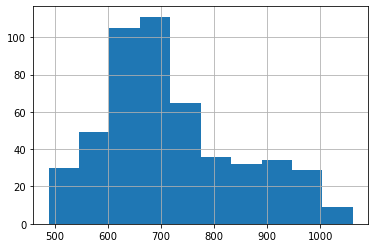

In [43]:
final_PnL = df_pathwisePortPnL.iloc[-1]
final_PnL.hist()

<AxesSubplot:>

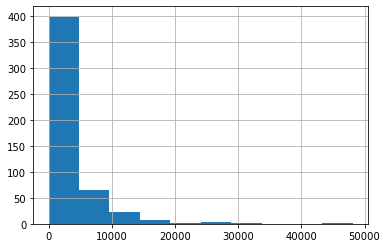

In [44]:
final_OptionValue = df_calloption.iloc[-1]
final_OptionValue.hist()

In [45]:
final_PnL.describe()

count     500.000000
mean      720.290655
std       126.657026
min       488.695988
25%       628.293742
50%       690.898144
75%       798.949728
max      1061.614196
Name: 6480, dtype: float64

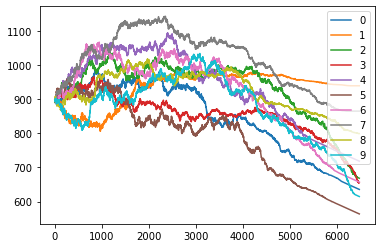

In [46]:
df_pathwisePortPnL.iloc[:,0:10].plot()
plt.show()

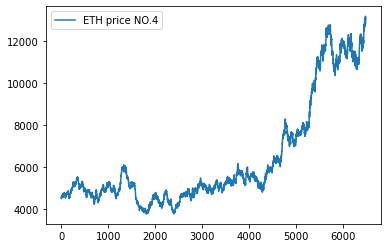

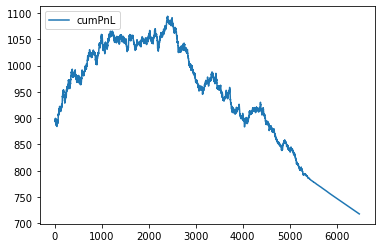

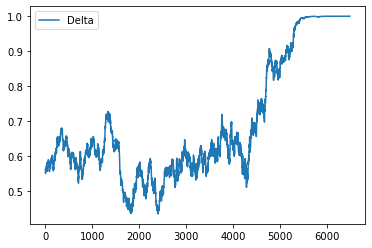

In [47]:
# unprofitable case
plt.plot(S[:,4], label='ETH price NO.4') 
plt.legend(loc="upper left")
plt.show()
df_pathwisePortPnL.iloc[:,4].plot(label='cumPnL')
plt.legend(loc="upper left")
plt.show()
df_callDelta.iloc[:,4].plot(label='Delta')
plt.legend(loc="upper left")
plt.show()

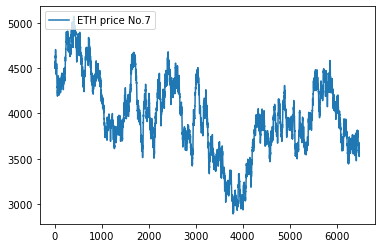

In [48]:
# profitable case
plt.plot(S[:,7], label='ETH price No.7') 
plt.legend(loc="upper left")
plt.show()

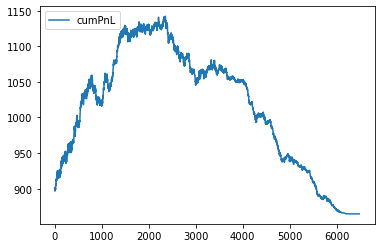

In [49]:
df_pathwisePortPnL.iloc[:,7].plot(label='cumPnL')
plt.legend(loc="upper left")
plt.show()

In [50]:
df_test['callValue'][0]

896.6674049351634

In [51]:
878/1093.8326779137647

0.8026821814050975

In [52]:
df_pathwisePortPnL.iloc[0] = df_test['callValue'][0]
# df_pathwisePortPnL
final_PnL_pct = df_pathwisePortPnL/df_pathwisePortPnL.iloc[0]
# final_PnL_pct
final_PnL_pct2 = df_pathwisePortPnL.iloc[-1]/df_test['callValue'][0]
# final_PnL_pct2
final_PnL_pct
# pd.options.display.float_format = '{:.2%}'.format

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001519,0.997467,1.001698,1.000824,0.996845,0.999626,1.003717,1.000185,0.999991,0.997111,...,0.999869,1.001566,1.002430,0.998965,1.003670,0.999821,0.999694,1.002123,1.005844,1.002672
2,1.000511,0.998484,1.001324,1.000943,0.998209,1.000645,1.000370,1.004587,1.000608,0.999207,...,0.998328,1.002277,1.004059,0.999077,1.002970,1.002019,0.994667,0.999045,1.008153,1.003919
3,1.000231,0.998707,1.001111,1.002668,0.999122,0.999623,0.996409,1.003806,1.002729,0.998322,...,1.000955,1.001553,1.004626,1.000035,1.000054,1.004192,0.996533,0.999090,1.009997,1.002302
4,1.000269,0.998607,1.001033,1.002290,0.998397,1.000549,0.996866,1.003147,1.005866,0.997353,...,0.998371,0.999345,1.007070,0.997501,1.001815,1.003789,0.996271,0.999093,1.012735,1.002034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6476,0.708854,1.046854,0.745377,0.730791,0.801138,0.628899,0.732832,0.964151,0.890814,0.685657,...,0.906080,0.778703,0.719528,0.762828,0.604200,0.667403,0.661233,0.811966,0.717564,0.861710
6477,0.708786,1.046854,0.745309,0.730739,0.801070,0.628830,0.732764,0.964151,0.890814,0.685588,...,0.906080,0.778634,0.719459,0.761645,0.604200,0.667334,0.661164,0.811897,0.716318,0.859153
6478,0.708717,1.046854,0.745240,0.730712,0.801001,0.628762,0.732695,0.964151,0.890814,0.685519,...,0.906080,0.778565,0.719391,0.760895,0.604200,0.667266,0.661095,0.811828,0.715156,0.856221
6479,0.708648,1.046854,0.745171,0.730710,0.800932,0.628693,0.732626,0.964151,0.890814,0.685450,...,0.906080,0.778497,0.719322,0.760374,0.604200,0.667197,0.661026,0.811760,0.713145,0.870589


In [53]:
final_PnL_pct

,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.001519,0.997467,1.001698,1.000824,0.996845,0.999626,1.003717,1.000185,0.999991,0.997111,...,0.999869,1.001566,1.002430,0.998965,1.003670,0.999821,0.999694,1.002123,1.005844,1.002672
2,1.000511,0.998484,1.001324,1.000943,0.998209,1.000645,1.000370,1.004587,1.000608,0.999207,...,0.998328,1.002277,1.004059,0.999077,1.002970,1.002019,0.994667,0.999045,1.008153,1.003919
3,1.000231,0.998707,1.001111,1.002668,0.999122,0.999623,0.996409,1.003806,1.002729,0.998322,...,1.000955,1.001553,1.004626,1.000035,1.000054,1.004192,0.996533,0.999090,1.009997,1.002302
4,1.000269,0.998607,1.001033,1.002290,0.998397,1.000549,0.996866,1.003147,1.005866,0.997353,...,0.998371,0.999345,1.007070,0.997501,1.001815,1.003789,0.996271,0.999093,1.012735,1.002034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6476,0.708854,1.046854,0.745377,0.730791,0.801138,0.628899,0.732832,0.964151,0.890814,0.685657,...,0.906080,0.778703,0.719528,0.762828,0.604200,0.667403,0.661233,0.811966,0.717564,0.861710
6477,0.708786,1.046854,0.745309,0.730739,0.801070,0.628830,0.732764,0.964151,0.890814,0.685588,...,0.906080,0.778634,0.719459,0.761645,0.604200,0.667334,0.661164,0.811897,0.716318,0.859153
6478,0.708717,1.046854,0.745240,0.730712,0.801001,0.628762,0.732695,0.964151,0.890814,0.685519,...,0.906080,0.778565,0.719391,0.760895,0.604200,0.667266,0.661095,0.811828,0.715156,0.856221
6479,0.708648,1.046854,0.745171,0.730710,0.800932,0.628693,0.732626,0.964151,0.890814,0.685450,...,0.906080,0.778497,0.719322,0.760374,0.604200,0.667197,0.661026,0.811760,0.713145,0.870589


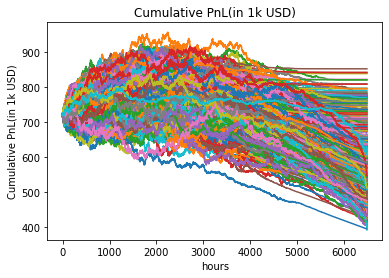

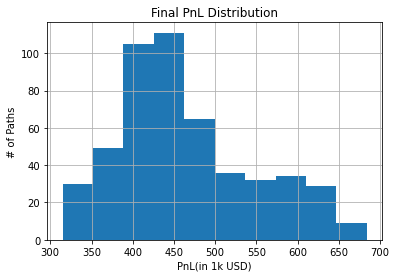

In [54]:
scale = 878/1093.8326779137647
df_pathwisePortPnL_temp = df_pathwisePortPnL * scale
ax = df_pathwisePortPnL_temp.plot(legend=None)
# plt.legend('Cumulative PnL%')

# ax.set_ylim(0, 1.6)
plt.title('Cumulative PnL(in 1k USD)')
plt.xlabel("hours")
plt.ylabel("Cumulative PnL(in 1k USD)")
plt.show()
final_PnL = scale * df_pathwisePortPnL_temp.iloc[-1]
final_PnL.hist(legend=None)
plt.title('Final PnL Distribution')
plt.xlabel("PnL(in 1k USD)")
plt.ylabel("# of Paths")
plt.show()

In [55]:
df_test['callValue'][0]

896.6674049351634

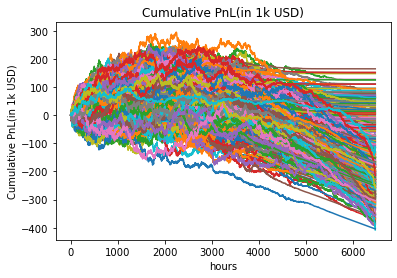

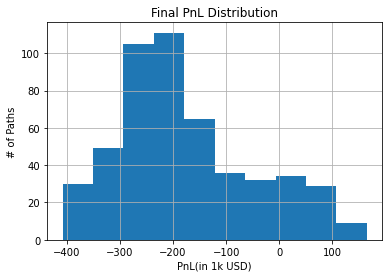

In [56]:
df_pathwisePnL_startzero = df_pathwisePortPnL-df_test['callValue'][0]
ax = df_pathwisePnL_startzero.plot(legend=None)
# plt.legend('Cumulative PnL%')

# ax.set_ylim(0, 1.6)
plt.title('Cumulative PnL(in 1k USD)')
plt.xlabel("hours")
plt.ylabel("Cumulative PnL(in 1k USD)")
plt.show()
final_PnL = df_pathwisePnL_startzero.iloc[-1]
final_PnL.hist(legend=None)
plt.title('Final PnL Distribution')
plt.xlabel("PnL(in 1k USD)")
plt.ylabel("# of Paths")
plt.show()

In [57]:
finalPnL_absValue = df_pathwisePortPnL.iloc[-1]
print("95% Final PnL confidence interval")
print(finalPnL_absValue.quantile([.025, .975]))    # 95% confidence interval, [2.5% 97.5%] percentile
print("99% Final PnL confidence interval")
print(finalPnL_absValue.quantile([.005, .995]))    # 99% confidence interval, [0.5%, 99.5%] percentile

95% Final PnL confidence interval
0.025    527.064643
0.975    982.380179
Name: 6480, dtype: float64
99% Final PnL confidence interval
0.005     501.702716
0.995    1046.462795
Name: 6480, dtype: float64


In [58]:
finalPnL_absValue_startzero = df_pathwisePnL_startzero.iloc[-1]
print("95% Final PnL confidence interval")
print(finalPnL_absValue_startzero.quantile([.025, .975]))    # 95% confidence interval, [2.5% 97.5%] percentile
print("99% Final PnL confidence interval")
print(finalPnL_absValue_startzero.quantile([.005, .995]))    # 99% confidence interval, [0.5%, 99.5%] percentile

95% Final PnL confidence interval
0.025   -369.602762
0.975     85.712774
Name: 6480, dtype: float64
99% Final PnL confidence interval
0.005   -394.964689
0.995    149.795390
Name: 6480, dtype: float64


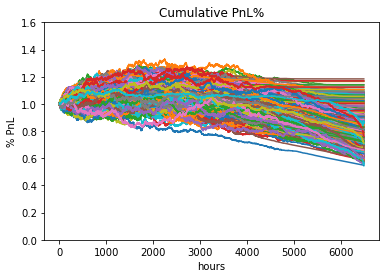

In [59]:
# final_PnL_pct = df_pathwisePortPnL
ax = final_PnL_pct.plot(legend=None)
# plt.legend('Cumulative PnL%')

ax.set_ylim(0, 1.6)
plt.title('Cumulative PnL%')
plt.xlabel("hours")
plt.ylabel("% PnL")
plt.show()
# final_PnL = df_pathwisePortPnL.iloc[-1]- df_test['callValue'][0]
# final_PnL_pct2 = df_pathwisePortPnL.iloc[-1]   # total PnL considering free call


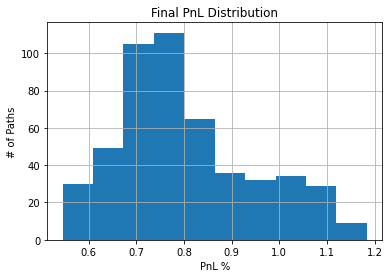

In [60]:
final_PnL_pct2.hist(legend=None)
plt.title('Final PnL Distribution')
plt.xlabel("PnL %")
plt.ylabel("# of Paths")
plt.show()

In [61]:
print("95% Final PnL confidence interval")
print(final_PnL_pct2.quantile([.025, .975]))    # 95% confidence interval, [2.5% 97.5%] percentile
print("99% Final PnL confidence interval")
print(final_PnL_pct2.quantile([.005, .995]))    # 99% confidence interval, [0.5%, 99.5%] percentile

95% Final PnL confidence interval
0.025    0.587804
0.975    1.095590
Name: 6480, dtype: float64
99% Final PnL confidence interval
0.005    0.559519
0.995    1.167058
Name: 6480, dtype: float64


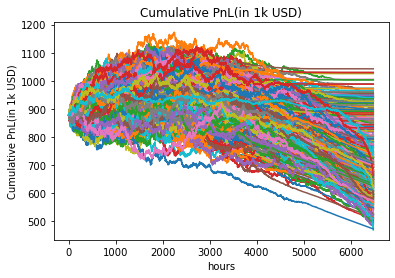

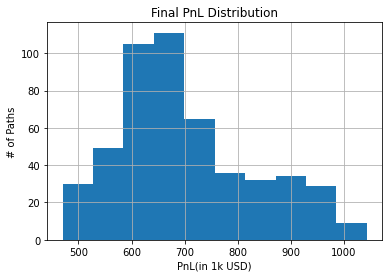

In [69]:
df_pathwisePnL_samescale = df_pathwisePortPnL-df_test['callValue'][0]+878
ax = df_pathwisePnL_samescale.plot(legend=None)
# plt.legend('Cumulative PnL%')

# ax.set_ylim(0, 1.6)
plt.title('Cumulative PnL(in 1k USD)')
plt.xlabel("hours")
plt.ylabel("Cumulative PnL(in 1k USD)")
plt.show()
final_PnL = df_pathwisePnL_samescale.iloc[-1]    # Final PnL after 6 months
final_PnL.hist(legend=None)
plt.title('Final PnL Distribution')
plt.xlabel("PnL(in 1k USD)")
plt.ylabel("# of Paths")
plt.show()

In [63]:
final_PnL_pct2_95_bool = final_PnL_pct2.between(final_PnL_pct2.quantile(.025), final_PnL_pct2.quantile(.975), inclusive=True)
final_PnL_pct2_99_bool = final_PnL_pct2.between(final_PnL_pct2.quantile(.005), final_PnL_pct2.quantile(.995), inclusive=True)

# final_PnL_pct2_95.hist(legend=None)
# plt.title('Final PnL Distribution(95% Confidence Interval)')
# plt.xlabel("PnL %")
# plt.ylabel("# of Paths")
# plt.show()

# final_PnL_pct2_99.hist(legend=None)
# plt.title('Final PnL Distribution(99% Confidence Interval)')
# plt.xlabel("PnL %")
# plt.ylabel("# of Paths")
# plt.show()

/var/folders/k_/swxk2_jn1dl6w_dbw9rz3x200000gp/T/ipykernel_15605/1928470560.py:1: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  final_PnL_pct2_95_bool = final_PnL_pct2.between(final_PnL_pct2.quantile(.025), final_PnL_pct2.quantile(.975), inclusive=True)
/var/folders/k_/swxk2_jn1dl6w_dbw9rz3x200000gp/T/ipykernel_15605/1928470560.py:2: FutureWarning: Boolean inputs to the `inclusive` argument are deprecated infavour of `both` or `neither`.
  final_PnL_pct2_99_bool = final_PnL_pct2.between(final_PnL_pct2.quantile(.005), final_PnL_pct2.quantile(.995), inclusive=True)


In [64]:
final_PnL_pct2_95_bool

0      True
1      True
2      True
3      True
4      True
       ... 
495    True
496    True
497    True
498    True
499    True
Name: 6480, Length: 500, dtype: bool

In [65]:
final_PnL_pct2[final_PnL_pct2 < 1.0].count()

431

In [66]:
min(final_PnL_pct2)

0.5450136644230312

path index with min cumulative PnL: [149]
path index with max cumulative PnL: [245]


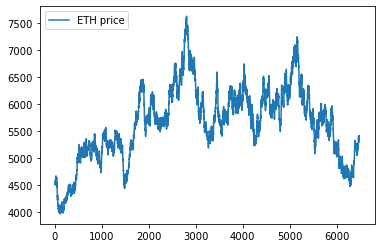

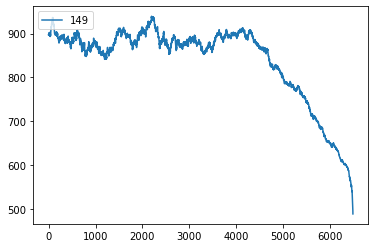

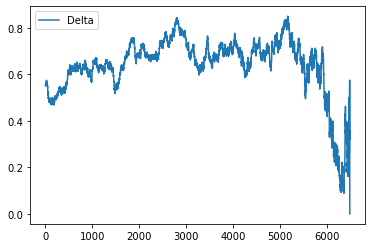

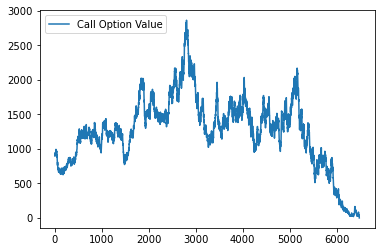

In [67]:
# min(df_pathwisePortPnL.iloc[-1])
min_index = np.where(df_pathwisePortPnL.iloc[-1] == min(df_pathwisePortPnL.iloc[-1]))[0]
print("path index with min cumulative PnL:", min_index)
max_index = np.where(df_pathwisePortPnL.iloc[-1] == max(df_pathwisePortPnL.iloc[-1]))[0]
print("path index with max cumulative PnL:", max_index)
# max_index = int(np.where(stdDev == max_stdDev))
# max_drawdownPath= max(df_pathwisePortPnL[-1], axis=0)
# unprofitable case
plt.plot(S[:,min_index], label='ETH price') 
plt.legend(loc="upper left")
plt.show()
df_pathwisePortPnL.iloc[:,min_index].plot(label='Min cumPnL')
plt.legend(loc="upper left")
plt.show()
plt.plot(df_callDelta.iloc[:,min_index], label='Delta') 
plt.legend(loc="upper left")
plt.show()
plt.plot(df_calloption.iloc[:,min_index], label='Call Option Value') 
plt.legend(loc="upper left")
plt.show()

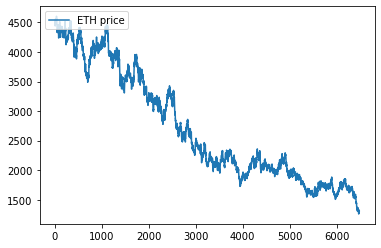

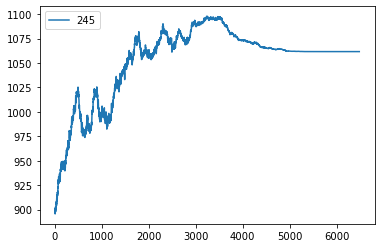

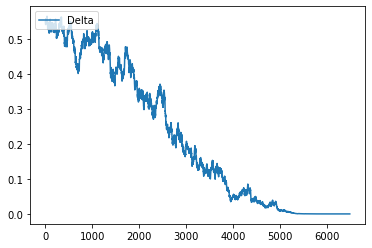

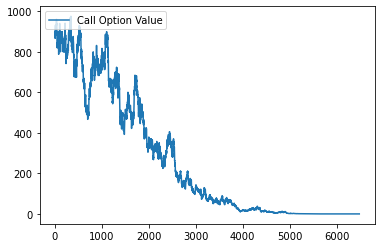

In [68]:
plt.plot(S[:,max_index], label='ETH price') 
plt.legend(loc="upper left")
plt.show()
df_pathwisePortPnL.iloc[:,max_index].plot(label='Min cumPnL')
plt.legend(loc="upper left")
plt.show()
plt.plot(df_callDelta.iloc[:,max_index], label='Delta') 
plt.legend(loc="upper left")
plt.show()
plt.plot(df_calloption.iloc[:,max_index], label='Call Option Value') 
plt.legend(loc="upper left")
plt.show()